In [1]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
day_reports = os.path.dirname(currentdir)
reports_dir = os.path.dirname(day_reports)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn") 

In [7]:
import numpy as np
import pandas as pd
import os
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd

from IPython.display import Image
from sklearn.metrics import confusion_matrix
from reporting_functions import (
    confusion_matrix_stats,
    plot_confusion_matrix_nn,
    get_tp_tn_lists,
    plot_loss,
    get_result_table,
    gather_experiment_results,
    gather_results_deprecated,
    get_file_content,
    get_result_table_target_pairs,
    get_multiclass_results,
)

from circuit_presets import (
    CIRCUIT_OPTIONS,
    POOLING_OPTIONS,
)
from preprocessing import filter_embedding_options, EMBEDDING_OPTIONS

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

In [8]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment_config.json"  # "experiment.txt"
experiment_time = "experiment_time.json"

In [13]:
experiment_id = 91 # 90 #91 #92 #93 #94 #98 #99
experiment_info = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)
experiment_time_info = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_time}"
)
result_data = gather_experiment_results(f"{experiments_path}/{experiment_id}")

In [14]:
experiment_info

{'ID': 91,
 'path': '../experiments',
 'data': {'target_pairs': [['pop', 'classical']]},
 'type': 'quantum',
 'preprocessing': {'reduction_method': 'pca',
  'scaler': {'Angle': [0, 1.5707963267948966],
   'ZZMap': [-1, 1],
   'IQP': [-1, 1]},
  'kwargs': {'ZZMap': {'depth': 3}, 'IQP': {'depth': 3}},
  'embedding_list': ['Angle', 'ZZMap', 'Amplitude', 'IQP', 'Angle-Compact']},
 'model': {'circuit_list': ['U_5'], 'classification_type': 'binary'},
 'train': {'iterations': 100, 'test_size': 0.3, 'random_state': 40},
 'extra_info': 'Main\n====\n Trying out multiple embeddings: [Angle,ZZMap,Amplitude,IQP,Angle-Compact]\n IQP and ZZMAP with depth 3 and scaled with minmax -1,1\n Angle scaled between 0, pi/2\n amplitude normalized'}

In [15]:
print(experiment_info["extra_info"])

Main
====
 Trying out multiple embeddings: [Angle,ZZMap,Amplitude,IQP,Angle-Compact]
 IQP and ZZMAP with depth 3 and scaled with minmax -1,1
 Angle scaled between 0, pi/2
 amplitude normalized


In [10]:
result_data.head()

,model,circuit,circuit_param_count,reduction_method,reduction_size,embedding_option,embedding_class,embedding_permutation,target_levels_list,target_levels,accuracy,precision,recall,f1,loss_train_history,loss_test_history,y_hat,y_test
0,pca-8-quantum-ZZMap-U_5-pop-classical,U_5,10.0,pca,8.0,ZZMap,ZZMap,1.0,"[pop, classical]",pop-classical,0.581,0.593,0.516,0.552,0 17.355 1 18.121 2 17.420 3 1...,0 17.012 1 16.797 2 17.065 3 1...,0 1 1 0 2 1 3 1 4 1 ....,0 1 1 1 2 0 3 0 4 1 ....
1,pca-8-quantum-IQP-U_5-pop-classical,U_5,10.0,pca,8.0,IQP,IQP,1.0,"[pop, classical]",pop-classical,0.677,0.824,0.452,0.583,0 19.834 1 19.605 2 18.111 3 1...,0 16.211 1 15.626 2 17.547 3 2...,0 1 1 0 2 1 3 1 4 1 ....,0 0 1 0 2 0 3 0 4 1 ....
2,pca-8-quantum-Angle-U_5-pop-classical,U_5,10.0,pca,8.0,Angle,Angle,1.0,"[pop, classical]",pop-classical,1.000,1.000,1.000,1.000,0 18.853 1 15.095 2 12.410 3 1...,0 14.147 1 14.430 2 10.695 3 ...,0 1 1 0 2 1 3 1 4 1 ....,0 1 1 0 2 1 3 1 4 1 ....
3,pca-16-quantum-Angle-Compact-U_5-pop-classical,U_5,10.0,pca,16.0,Angle-Compact,Angle-Compact,1.0,"[pop, classical]",pop-classical,0.500,0.500,1.000,0.667,0 16.716 1 18.792 2 16.832 3 1...,0 19.785 1 18.489 2 17.967 3 1...,0 1 1 0 2 1 3 1 4 1 ....,0 1 1 1 2 1 3 1 4 1 ....
4,pca-32-quantum-Amplitude-U_5-pop-classical,U_5,10.0,pca,32.0,Amplitude,Amplitude,1.0,"[pop, classical]",pop-classical,0.500,0.500,1.000,0.667,0 21.632 1 23.462 2 15.081 3 1...,0 15.446 1 17.264 2 24.190 3 1...,0 1 1 0 2 1 3 1 4 1 ....,0 1 1 1 2 1 3 1 4 1 ....


In [11]:
result_data.shape

(5, 18)

In [12]:
get_result_table(result_data, ["circuit", "embedding_option", "target_levels"], "accuracy")

target_levels,pop-classical,circuit Average
"(U_5, Amplitude)",0.500,0.500
"(U_5, Angle)",1.000,1.000
"(U_5, Angle-Compact)",0.500,0.500
"(U_5, IQP)",0.677,0.677
"(U_5, ZZMap)",0.581,0.581
embedding_option Average,0.652,0.652


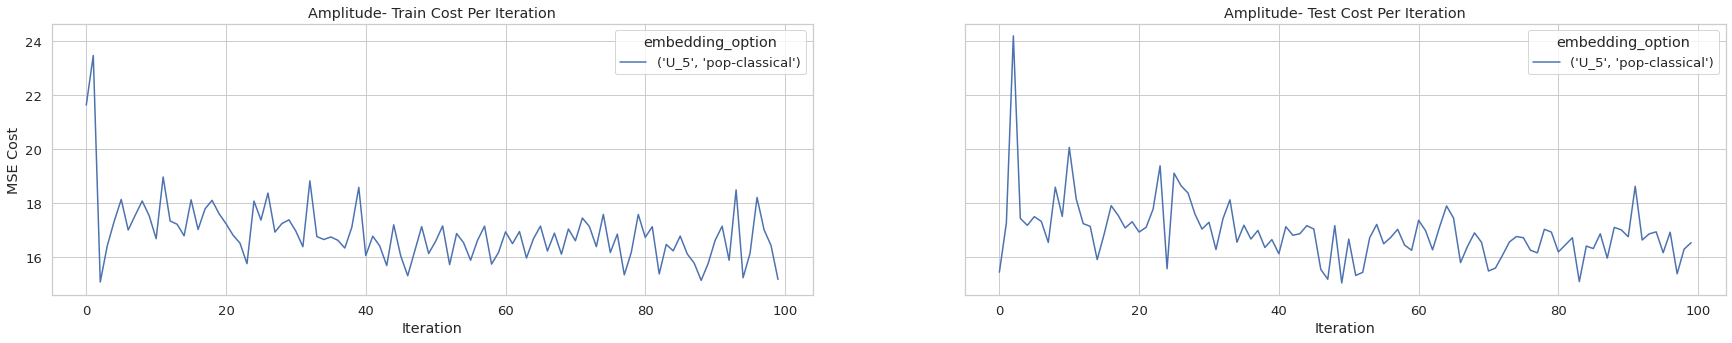

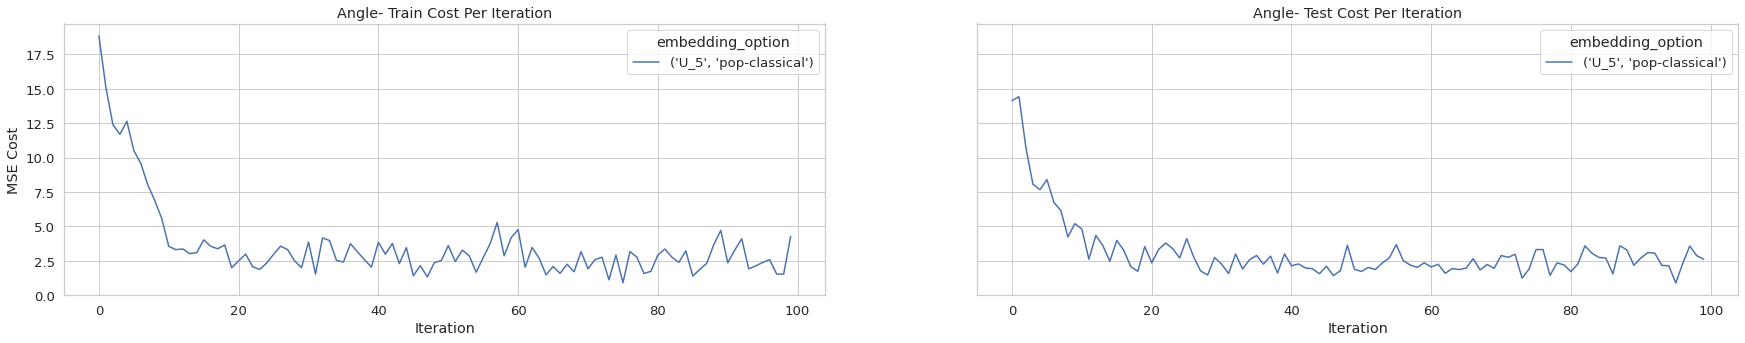

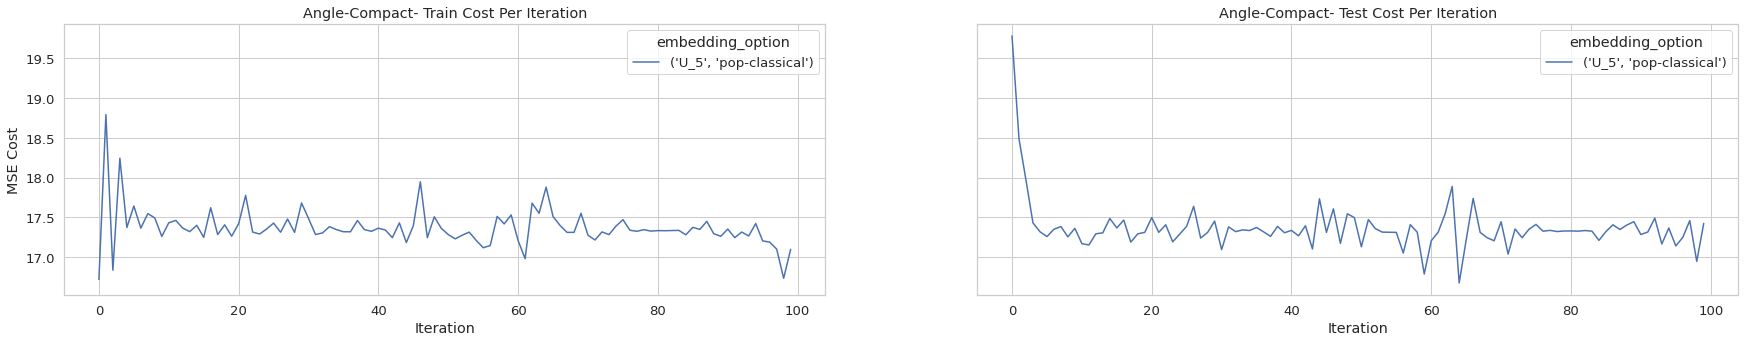

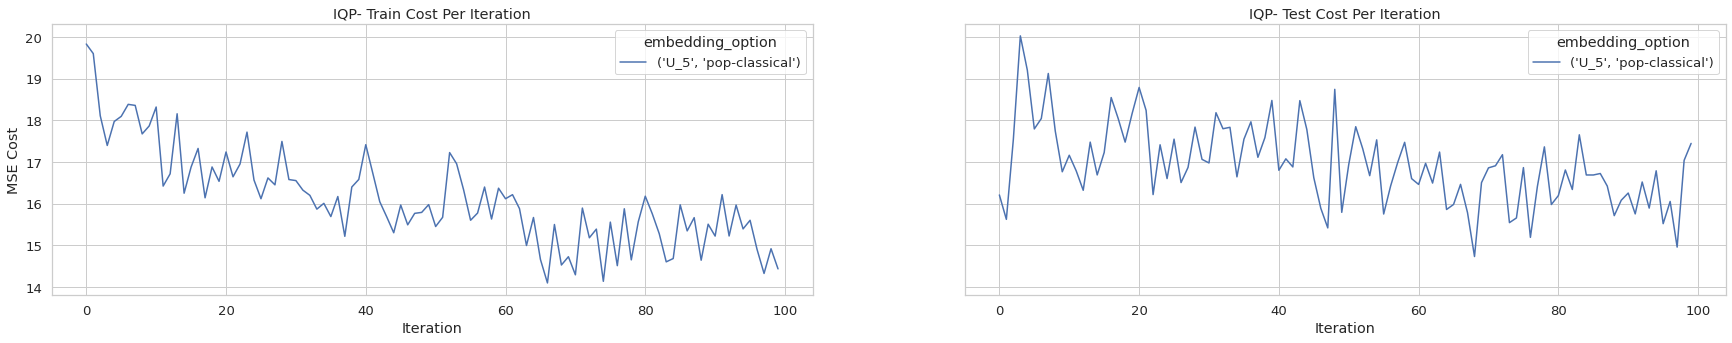

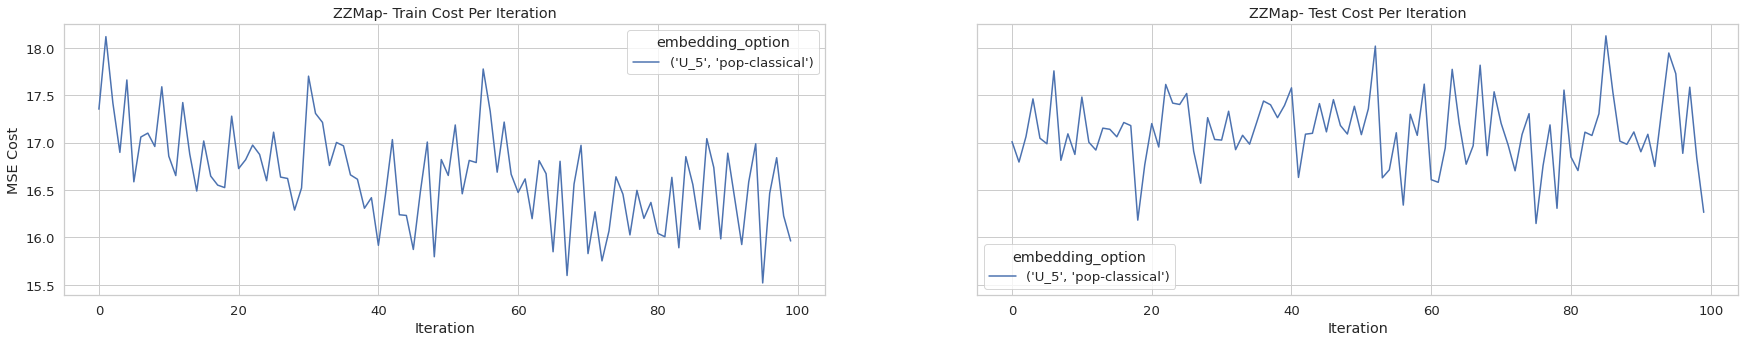

In [13]:
#plot_loss(result_data, "circuit", "embedding_option", figsize=(28, 5))
plot_loss(result_data, ["embedding_option", "circuit", "target_levels"], figsize=(30, 5))